# Generating Proximity to good schools (R)

In [1]:
# Import libraries
library(sf)
library(data.table)
library(ggplot2)
library(tmap)
library(tidygeocoder)
library(leaflet)
library(dplyr)
library(osmdata)
library(tmaptools)
library(tidyr)
library(readr)

Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Data (c) OpenStreetMap contributors, ODbL 1.0. https://www.openstreetmap.org/copyright



In [2]:
# Specify data directory
data_path = "data/schools_geo"

# Check what files we have
list.files(data_path)

[1] "Brighton_and_Hove_link_13082022.csv" "Brighton-DEM.tif"                   
 [3] "brightonhove_1667288932.zip"         "brightonhove.pbf"                   
 [5] "brightonhove.pbf.mapdb"              "brightonhove.pbf.mapdb.p"           
 [7] "ks2_hist_df.csv"                     "ks4_hist_df.csv"                    
 [9] "network_settings.json"               "network.dat"                        
[11] "ONSPD_MAY_2023_UK_BN.csv"            "secschools_geo_both.csv"            
[13] "secschools_geo_bus.csv"              "secschools_geo_walk.csv"            
[15] "secschools_geocoded.dbf"             "secschools_geocoded.prj"            
[17] "secschools_geocoded.shp"             "secschools_geocoded.shx"            
[19] "shapefiles"

## Extract postcodes from Brighton and Hove link to run analysis on. 

In [3]:
## Load priceper postcodes
priceper = read_csv("schools_geo/Brighton_and_Hove_link_13082022.csv")
head(priceper)

Rows: 114152 Columns: 16
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): propertytype, duration, postcode, lad21cd, transactionid, CONSTRUC...
dbl  (9): priceper, year, price, id, tfarea, numberrooms, classt, CURRENT_EN...
date (1): dateoftransfer

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


priceper,year,dateoftransfer,propertytype,duration,price,postcode,lad21cd,transactionid,id,tfarea,numberrooms,classt,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,CONSTRUCTION_AGE_BAND
<dbl>,<dbl>,<date>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4244.731,2015,2015-11-13,F,L,290000,BN1 1AD,E06000043,{288DCE29-0585-E510-E050-A8C06205480E},3268426,68.32,3,11,69,76,England and Wales: before 1900
2927.400,2003,2003-02-21,F,L,200000,BN1 1AD,E06000043,{8F424A5C-E6DD-492F-8827-7AF9523BB665},3268426,68.32,3,11,69,76,England and Wales: before 1900
3496.503,2013,2013-12-04,F,L,500000,BN1 1AD,E06000043,{AECCFEF8-D159-4688-B479-62C68F590D73},3279748,143.00,4,11,67,78,England and Wales: 1930-1949
3220.141,2006,2006-11-02,F,L,220000,BN1 1AD,E06000043,{4863D52D-C206-4176-9706-A19CDFA1678E},3268426,68.32,3,11,69,76,England and Wales: before 1900
1816.084,2004,2004-08-26,F,L,259700,BN1 1AD,E06000043,{DEC7C004-0B15-42DA-8620-A4D8B25855E5},3279748,143.00,4,11,67,78,England and Wales: 1930-1949
3146.853,2017,2017-03-31,F,L,450000,BN1 1AD,E06000043,{4E95D757-551D-EDA1-E050-A8C0630539E2},3328370,143.00,5,11,58,81,England and Wales: before 1900


In [4]:
unique_postcodes <- unique(priceper$postcode)

In [5]:
postcode_dir <- data.frame(postcode = unique_postcodes)
head(postcode_dir)

,postcode
,<chr>
1,BN1 1AD
2,BN1 1AJ
3,BN1 1AL
4,BN1 1AN
5,BN1 1AP
6,BN1 1BG


In [6]:
nrow(postcode_dir)

[1] 3902

In [7]:
postcode_ref = read_csv("schools_geo/ONSPD_MAY_2023_UK_BN.csv")

Rows: 35547 Columns: 53
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (42): pcd, pcd2, pcds, oscty, ced, oslaua, osward, parish, osnrth1m, osh...
dbl (10): dointr, doterm, usertype, oseast1m, osgrdind, streg, ur01ind, lat,...
lgl  (1): lep2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
# Load postcode data
keep <- c("pcds", "lat", "long")
postcode_df = postcode_ref[keep]
head(postcode_df)

pcds,lat,long
<chr>,<dbl>,<dbl>
BN1 1AA,50.82633,-0.140818
BN1 1AB,50.82296,-0.141790
BN1 1AD,50.82169,-0.142167
BN1 1AE,50.82138,-0.141753
BN1 1AF,50.82248,-0.141426
BN1 1AG,50.82292,-0.142871


In [9]:
## left join postcode_df to unique_postcodes 
brighton_postcodes <- left_join(postcode_dir, postcode_df, by=c("postcode" = "pcds"))

In [10]:
nrow(brighton_postcodes)

[1] 3902

In [11]:
brighton_houses <- brighton_postcodes%>%
  #remove NAs or 0
  filter(long != 0 )%>%
  filter(lat != 0)%>%
  st_as_sf(., coords = c("long","lat"), 
                   crs = 4326)

In [12]:
names(brighton_houses)[names(brighton_houses) == "postcode"] <- "id"

In [13]:
head(brighton_houses)

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,id,geometry
,<chr>,<POINT [°]>
1,BN1 1AD,POINT (-0.142167 50.82169)
2,BN1 1AJ,POINT (-0.14256 50.82145)
3,BN1 1AL,POINT (-0.142961 50.82136)
4,BN1 1AN,POINT (-0.1435 50.82209)
5,BN1 1AP,POINT (-0.143707 50.8208)
6,BN1 1BG,POINT (-0.1421 50.82231)


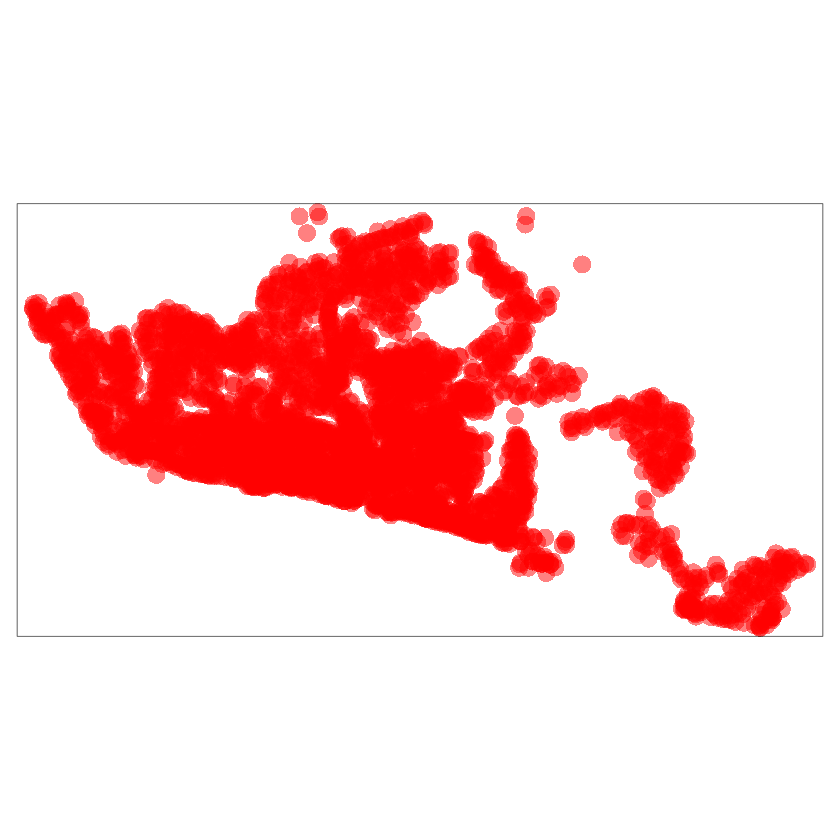

In [14]:
tm_shape(brighton_houses) + tm_symbols(size=1, col="red", border.lwd=0, alpha=0.5)

### Sec schools data

In [14]:
## leftjoin secondary schools with lat lon data
sec_schools <- read_csv("schools_geo/ks4_hist_df.csv")
head(sec_schools)

Rows: 10 Columns: 23
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (22): School name, School postcode, 2000, 2001, 2002, 2003, 2004, 2005, ...
dbl  (1): LAESTAB

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


LAESTAB,School name,School postcode,2000,2001,2002,2003,2004,2005,2006,⋯,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
8464605,Cardinal Newman Catholic School,BN3 6ND,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Good,Outstanding,⋯,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding
8464012,Varndean School,BN1 6NP,Outstanding,Good,Outstanding,Good,Outstanding,Outstanding,Outstanding,⋯,Good,Outstanding,Good,Good,Good,Good,Good,Good,Outstanding,Good
8464016,Dorothy Stringer School,BN1 6PZ,Outstanding,Outstanding,Outstanding,Good,Outstanding,Outstanding,Outstanding,⋯,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding
8464018,Longhill High School,BN2 7FR,Good,Outstanding,Good,Good,Good,Good,Good,⋯,Good,Poor,Poor,Poor,Good,Poor,Poor,Poor,Poor,Poor
8464067,Blatchington Mill School,BN3 7BW,Good,Good,Good,Outstanding,Good,Outstanding,Good,⋯,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Good,Outstanding
8464068,Hove Park School and Sixth Form Centre,BN3 7BN,Good,Good,Good,Poor,Poor,Poor,Poor,⋯,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good


In [15]:
names(postcode_df)[names(postcode_df) == "pcds"] <- "id"

In [16]:
sec_schools <- left_join(sec_schools, postcode_df, by=c("School postcode" = "id"))
sec_schools

LAESTAB,School name,School postcode,2000,2001,2002,2003,2004,2005,2006,⋯,2012,2013,2014,2015,2016,2017,2018,2019,lat,long
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
8464605,Cardinal Newman Catholic School,BN3 6ND,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Good,Outstanding,⋯,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,50.83681,-0.158368
8464012,Varndean School,BN1 6NP,Outstanding,Good,Outstanding,Good,Outstanding,Outstanding,Outstanding,⋯,Good,Good,Good,Good,Good,Good,Outstanding,Good,50.85030,-0.137138
8464016,Dorothy Stringer School,BN1 6PZ,Outstanding,Outstanding,Outstanding,Good,Outstanding,Outstanding,Outstanding,⋯,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,50.84895,-0.143414
8464018,Longhill High School,BN2 7FR,Good,Outstanding,Good,Good,Good,Good,Good,⋯,Poor,Poor,Good,Poor,Poor,Poor,Poor,Poor,50.81900,-0.067270
8464067,Blatchington Mill School,BN3 7BW,Good,Good,Good,Outstanding,Good,Outstanding,Good,⋯,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Outstanding,Good,Outstanding,50.84530,-0.184029
8464068,Hove Park School and Sixth Form Centre,BN3 7BN,Good,Good,Good,Poor,Poor,Poor,Poor,⋯,Good,Good,Good,Good,Good,Good,Good,Good,50.84087,-0.179613
8464068,Hove Park School and Sixth Form Centre,BN3 8AA,Good,Good,Good,Poor,Poor,Poor,Poor,⋯,Good,Good,Good,Good,Good,Good,Good,Good,50.84316,-0.202294
8464001,Portslade Aldridge Community Academy,BN41 2WS,Poor,Poor,Poor,Poor,Good,Good,Good,⋯,Poor,Poor,Poor,Good,Poor,Poor,Poor,Poor,50.85064,-0.225774
8464072,Patcham High School,BN1 8PB,Poor,Poor,Poor,Poor,Poor,Poor,Poor,⋯,Good,Good,Poor,Poor,Good,Good,Good,Good,50.86219,-0.143940


In [18]:
# convert st as sf 

In [17]:
sec_schools_geocoded <- sec_schools%>%
  #remove NAs or 0
  filter(long != 0 )%>%
  filter(lat != 0)%>%
  st_as_sf(., coords = c("long","lat"), 
                   crs = 4326)

In [65]:
names(sec_schools_geocoded)[names(sec_schools_geocoded) == "School postcode"] <- "id"
names(sec_schools_geocoded)[names(sec_schools_geocoded) == "School name"] <- "school_name"

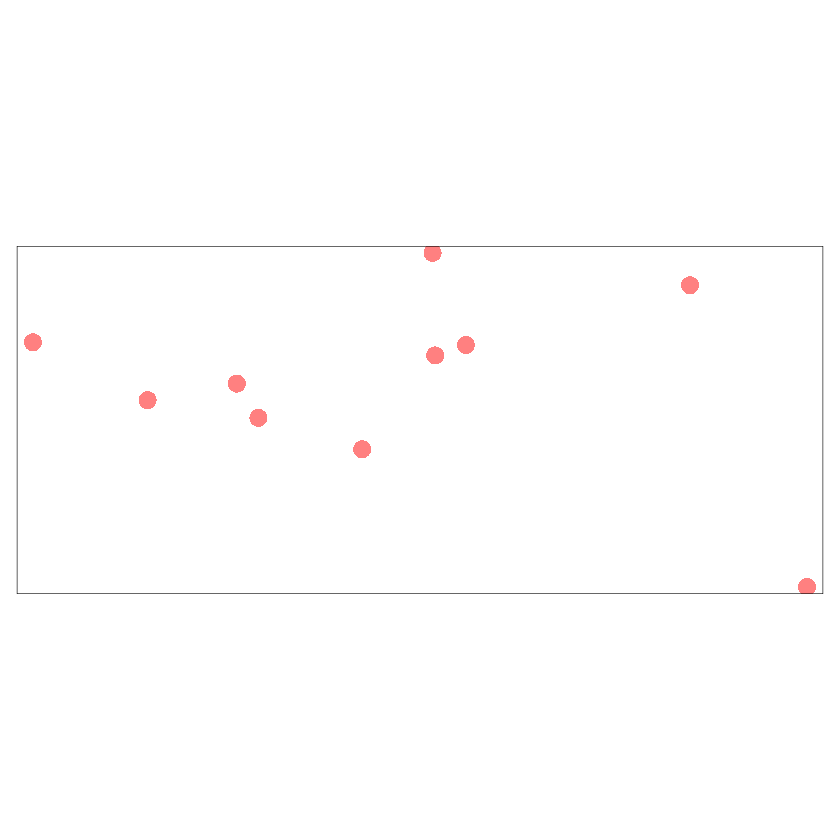

In [20]:
tm_shape(sec_schools_geocoded) + tm_symbols(size=1, col="red", border.lwd=0, alpha=0.5)

## r5r Prep

In [11]:
# Allow 6 GiB of memory
options(java.parameters = "-Xmx6G")

# After allocating the memory import the r5r
library(r5r)

# Create the routable network by indicating the path where OSM, GTFS and possible DEM data are stored
r5r_core = setup_r5(data_path = data_path)

Please make sure you have already allocated some memory to Java by running:
  options(java.parameters = '-Xmx2G').
You should replace '2G' by the amount of memory you'll require. Currently, Java memory is set to -Xmx6G

Using cached R5 version from /home/jtej22/miniconda3/envs/r5/lib/R/library/r5r/jar/r5-v6.9-all.jar


Using cached network.dat from schools_geo/network.dat



# Proximity to nearest school variable
Using brighton_houses as dests and to store r5r generated data, using sec_schools_geocoded as origins

In [66]:
# Set parameters
mode = c("WALK")
max_walk_time = 100 # minutes
max_trip_duration = 100 # minutes
departure_datetime = as.POSIXct("01-12-2022 8:30:00",
                                 format = "%d-%m-%Y %H:%M:%S")

# Calculate the travel time matrix by Transit
ttm_nearest_sec = travel_time_matrix(r5r_core = r5r_core,
                          origins = brighton_houses,
                          destinations = sec_schools_geocoded,
                          mode = mode,
                          departure_datetime = departure_datetime,
                          max_walk_time = max_walk_time,
                          max_trip_duration = max_trip_duration)

head(ttm_nearest_sec)

from_id,to_id,travel_time_p50
<chr>,<chr>,<int>
BN1 1AD,BN3 6ND,50
BN1 1AD,BN1 6NP,71
BN1 1AD,BN1 6PZ,76
BN1 1AD,BN3 7BW,86
BN1 1AD,BN3 7BN,74
BN1 1AD,BN1 8PB,96


In [67]:
nrow(ttm_nearest_sec)

[1] 22633

In [1]:
## Handle duplicates for walk travel time to rail stations
ttm_nearest_sec <- ttm_nearest_sec %>%
  group_by(from_id) %>% 
  arrange(travel_time_p50) %>%
  slice_head(n = 1) %>% 
  ungroup()

SyntaxError: invalid syntax (1835282717.py, line 1)

In [69]:
nrow(ttm_nearest_sec)
##3902 correct

[1] 3902

In [70]:
# Check for duplicates in 'id' column of df1
duplicates_ttm_nearest_sec <- duplicated(ttm_nearest_sec$from_id)
# Check for duplicates in 'id' column of df2
duplicates_brighton_houses <- duplicated(brighton_houses$id)

# Check if there are duplicates in df1 or df2
if (any(duplicates_ttm_nearest_sec) || any(duplicates_brighton_houses)) {
  print("Duplicates found! Please handle duplicates before performing left join.")
} else {
  # Perform the left join, walk time bands from rail station to postcodes
  brighton_houses <- left_join(brighton_houses, ttm_nearest_sec, by=c(id = "from_id"))
  # Print the resulting merged data frame
  print(brighton_houses)
}

Simple feature collection with 3902 features and 3 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -0.235465 ymin: 50.80051 xmax: -0.02655 ymax: 50.87138
Geodetic CRS:  WGS 84
First 10 features:
        id   to_id travel_time_p50                   geometry
1  BN1 1AD BN3 6ND              50 POINT (-0.142167 50.82169)
2  BN1 1AJ BN3 6ND              50  POINT (-0.14256 50.82145)
3  BN1 1AL BN3 6ND              49 POINT (-0.142961 50.82136)
4  BN1 1AN BN3 6ND              47   POINT (-0.1435 50.82209)
5  BN1 1AP BN3 6ND              51  POINT (-0.143707 50.8208)
6  BN1 1BG BN3 6ND              48   POINT (-0.1421 50.82231)
7  BN1 1EA BN3 6ND              51  POINT (-0.13946 50.82263)
8  BN1 1EG BN3 6ND              53 POINT (-0.138162 50.82136)
9  BN1 1EH BN3 6ND              53 POINT (-0.137542 50.82162)
10 BN1 1EJ BN3 6ND              56 POINT (-0.136211 50.82151)


In [71]:
print(sum(is.na(brighton_houses$travel_time_p50)))
#0 nas

[1] 0


In [72]:
colnames(brighton_houses)[colnames(brighton_houses) == "travel_time_p50"] <- "walk_nearest_sec"

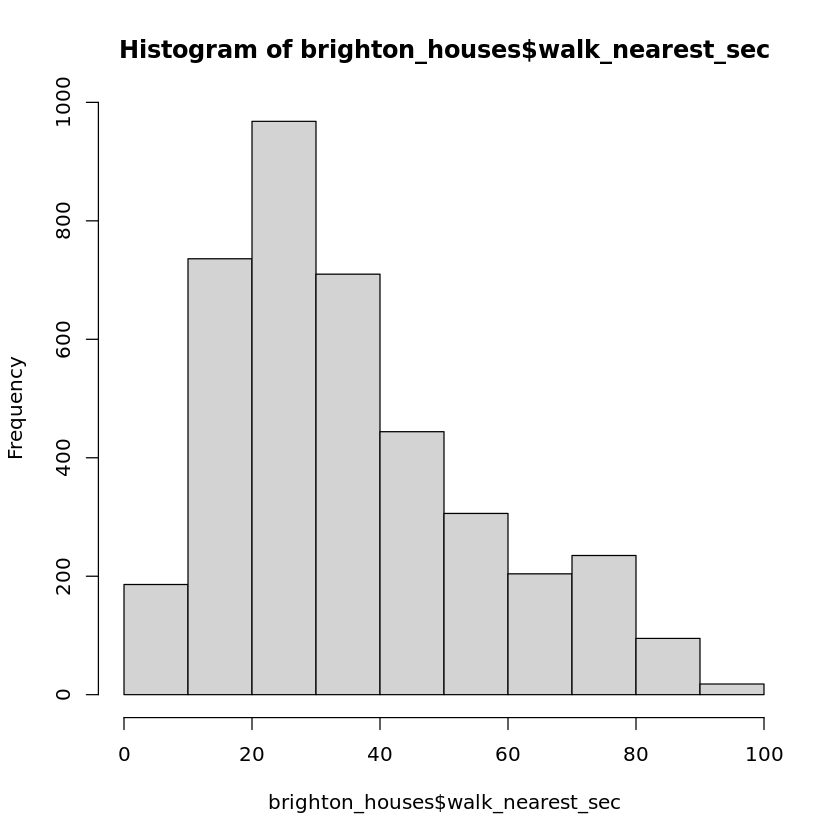

In [73]:
hist(brighton_houses$walk_nearest_sec)

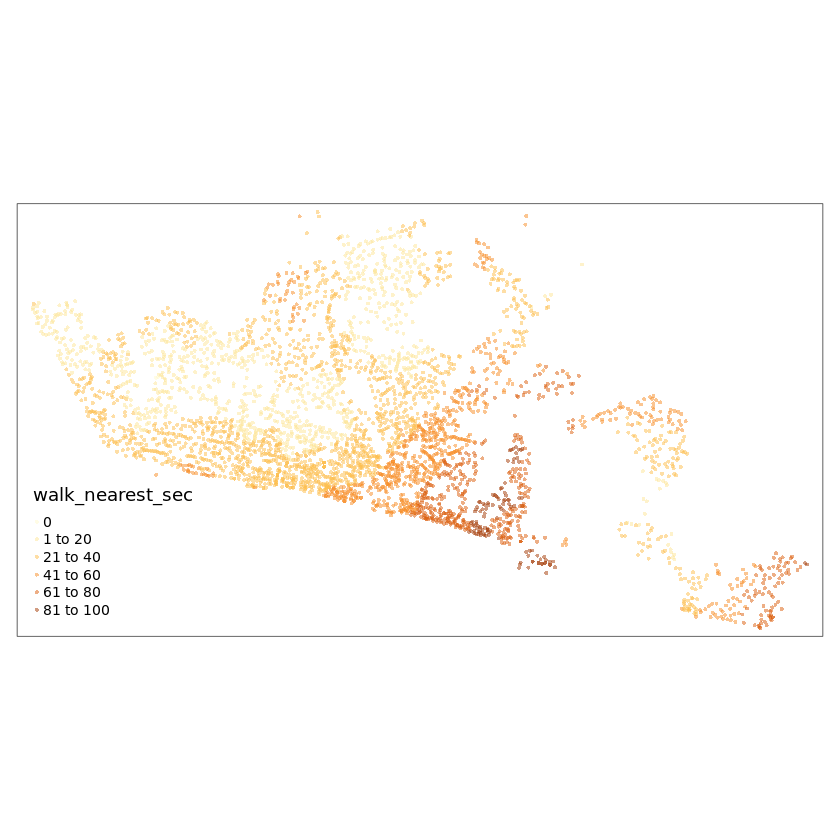

In [30]:
tm_shape(brighton_houses) + tm_symbols(size=0.05, col="walk_nearest_sec", border.lwd=0, alpha=0.5)

In [ ]:
#use to_id to generate school name
#from postcode to school name
postcode_school_dict <- setNames(sec_schools_geocoded$school_name, sec_schools_geocoded$id)

# Use match() and the dictionary to replace postcodes with school names
brighton_houses$nearest_sec_name <- postcode_school_dict[match(brighton_houses$to_id, names(postcode_school_dict))]


In [31]:
brighton_houses$to_id <- NULL
head(brighton_houses)

,id,walk_nearest_sec,geometry
,<chr>,<int>,<POINT [°]>
1,BN1 1AD,50,POINT (-0.142167 50.82169)
2,BN1 1AJ,50,POINT (-0.14256 50.82145)
3,BN1 1AL,49,POINT (-0.142961 50.82136)
4,BN1 1AN,47,POINT (-0.1435 50.82209)
5,BN1 1AP,51,POINT (-0.143707 50.8208)
6,BN1 1BG,48,POINT (-0.1421 50.82231)


## Quality of schools:
Walking time to nearest Outstanding/Good school for each year

In [74]:
head(sec_schools_geocoded)

LAESTAB School name                            id      2000       
1 8464605 Cardinal Newman Catholic School        BN3 6ND Outstanding
2 8464012 Varndean School                        BN1 6NP Outstanding
3 8464016 Dorothy Stringer School                BN1 6PZ Outstanding
4 8464018 Longhill High School                   BN2 7FR Good       
5 8464067 Blatchington Mill School               BN3 7BW Good       
6 8464068 Hove Park School and Sixth Form Centre BN3 7BN Good       
  2001        2002        2003        2004        2005        2006        ⋯
1 Outstanding Outstanding Outstanding Outstanding Good        Outstanding ⋯
2 Good        Outstanding Good        Outstanding Outstanding Outstanding ⋯
3 Outstanding Outstanding Good        Outstanding Outstanding Outstanding ⋯
4 Outstanding Good        Good        Good        Good        Good        ⋯
5 Good        Good        Outstanding Good        Outstanding Good        ⋯
6 Good        Good        Poor        Poor        Poor        Poor        ⋯
  2011        2012        2013        2014        2015        2016       
1 Outstanding Outstanding Outstanding Outstanding Outstanding Outstanding
2 Outstanding Good        Good        Good        Good        Good       
3 Outstanding Outstanding Outstanding Outstanding Outstanding Outstanding
4 Poor        Poor        Poor        Good        Poor        Poor       
5 Outstanding Outstanding Outstanding Outstanding Outstanding Outstanding
6 Good        Good        Good        Good        Good        Good       
  2017        2018        2019        geometry                  
1 Outstanding Outstanding Outstanding POINT (-0.158368 50.83681)
2 Good        Outstanding Good        POINT (-0.137138 50.8503) 
3 Outstanding Outstanding Outstanding POINT (-0.143414 50.84895)
4 Poor        Poor        Poor        POINT (-0.06727 50.819)   
5 Outstanding Good        Outstanding POINT (-0.184029 50.8453) 
6 Good        Good        Good        POINT (-0.179613 50.84087)

In [35]:
good_2000 <- sec_schools_geocoded[sec_schools_geocoded$`2000` %in% c("Good", "Outstanding"), ]

In [36]:
# Set parameters
mode = c("WALK")
max_walk_time = 30 # minutes
max_trip_duration = 30 # minutes
departure_datetime = as.POSIXct("01-12-2022 8:30:00",
                                 format = "%d-%m-%Y %H:%M:%S")

# Calculate the travel time matrix by Transit
ttm_good_walk = travel_time_matrix(r5r_core = r5r_core,
                          origins = sec_schools_geocoded,
                          destinations = brighton_houses,
                          mode = mode,
                          departure_datetime = departure_datetime,
                          max_walk_time = max_walk_time,
                          max_trip_duration = max_trip_duration)

head(ttm_good_walk)

from_id,to_id,travel_time_p50
<chr>,<chr>,<int>
BN3 6ND,BN1 3AG,30
BN3 6ND,BN1 3AH,29
BN3 6ND,BN1 3AJ,30
BN3 6ND,BN1 3AP,29
BN3 6ND,BN1 3AQ,29
BN3 6ND,BN1 3AU,30


In [37]:
ttm_good_walk <- ttm_good_walk %>%
  group_by(to_id) %>% 
  arrange(travel_time_p50) %>%
  slice_head(n = 1) %>% 
  ungroup()

In [38]:
# Check for duplicates in 'id' column of df1
duplicates_ttm_good_walk <- duplicated(ttm_good_walk$to_id)
# Check for duplicates in 'id' column of df2
duplicates_brighton_houses <- duplicated(brighton_houses$id)

# Check if there are duplicates in df1 or df2
if (any(duplicates_ttm_good_walk) || any(duplicates_brighton_houses)) {
  print("Duplicates found! Please handle duplicates before performing left join.")
} else {
  # Perform the left join, walk time bands from rail station to postcodes
  brighton_houses <- left_join(brighton_houses, ttm_good_walk, by=c(id = "to_id"))
  # Print the resulting merged data frame
  print(brighton_houses)
}

Simple feature collection with 3902 features and 5 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -0.235465 ymin: 50.80051 xmax: -0.02655 ymax: 50.87138
Geodetic CRS:  WGS 84
First 10 features:
        id   to_id walk_nearest_sec from_id travel_time_p50
1  BN1 1AD BN3 6ND               50    <NA>              NA
2  BN1 1AJ BN3 6ND               50    <NA>              NA
3  BN1 1AL BN3 6ND               49    <NA>              NA
4  BN1 1AN BN3 6ND               47    <NA>              NA
5  BN1 1AP BN3 6ND               51    <NA>              NA
6  BN1 1BG BN3 6ND               48    <NA>              NA
7  BN1 1EA BN3 6ND               51    <NA>              NA
8  BN1 1EG BN3 6ND               53    <NA>              NA
9  BN1 1EH BN3 6ND               53    <NA>              NA
10 BN1 1EJ BN3 6ND               56    <NA>              NA
                     geometry
1  POINT (-0.142167 50.82169)
2   POINT (-0.14256 50.82145)
3  POINT (-0.142961 50.82136)
4    P

In [39]:
# Create a new categorical column based on travel time
# Define the breaks for the bands (including endpoints)
breaks <- c(0, 5, 10, 15, 20, 25, 30)
#, 25, 30)

# Define the labels for each band
labels <- c("0-5_mins", "5-10_mins", "10-15_mins", "15-20_mins", "20-25_mins", "25-30_mins")

# Create the categorical column based on travel time bands
brighton_houses$good_walk_2000 <- cut(brighton_houses$travel_time_p50, breaks = breaks, labels = labels, include.lowest = TRUE, right = FALSE)

# Print the updated data frame
head(brighton_houses)

,id,to_id,walk_nearest_sec,from_id,travel_time_p50,geometry,good_walk_2000
,<chr>,<chr>,<int>,<chr>,<int>,<POINT [°]>,<fct>
1,BN1 1AD,BN3 6ND,50,NA,NA,POINT (-0.142167 50.82169),NA
2,BN1 1AJ,BN3 6ND,50,NA,NA,POINT (-0.14256 50.82145),NA
3,BN1 1AL,BN3 6ND,49,NA,NA,POINT (-0.142961 50.82136),NA
4,BN1 1AN,BN3 6ND,47,NA,NA,POINT (-0.1435 50.82209),NA
5,BN1 1AP,BN3 6ND,51,NA,NA,POINT (-0.143707 50.8208),NA
6,BN1 1BG,BN3 6ND,48,NA,NA,POINT (-0.1421 50.82231),NA


In [40]:
## Drop the columns from_id and travel_time_p50
brighton_houses <- brighton_houses[, !(names(brighton_houses) %in% c('from_id', 'travel_time_p50'))]

# Print the updated data frame
print(brighton_houses)

Simple feature collection with 3902 features and 4 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -0.235465 ymin: 50.80051 xmax: -0.02655 ymax: 50.87138
Geodetic CRS:  WGS 84
First 10 features:
        id   to_id walk_nearest_sec                   geometry good_walk_2000
1  BN1 1AD BN3 6ND               50 POINT (-0.142167 50.82169)           <NA>
2  BN1 1AJ BN3 6ND               50  POINT (-0.14256 50.82145)           <NA>
3  BN1 1AL BN3 6ND               49 POINT (-0.142961 50.82136)           <NA>
4  BN1 1AN BN3 6ND               47   POINT (-0.1435 50.82209)           <NA>
5  BN1 1AP BN3 6ND               51  POINT (-0.143707 50.8208)           <NA>
6  BN1 1BG BN3 6ND               48   POINT (-0.1421 50.82231)           <NA>
7  BN1 1EA BN3 6ND               51  POINT (-0.13946 50.82263)           <NA>
8  BN1 1EG BN3 6ND               53 POINT (-0.138162 50.82136)           <NA>
9  BN1 1EH BN3 6ND               53 POINT (-0.137542 50.82162)           <NA>
10 BN1

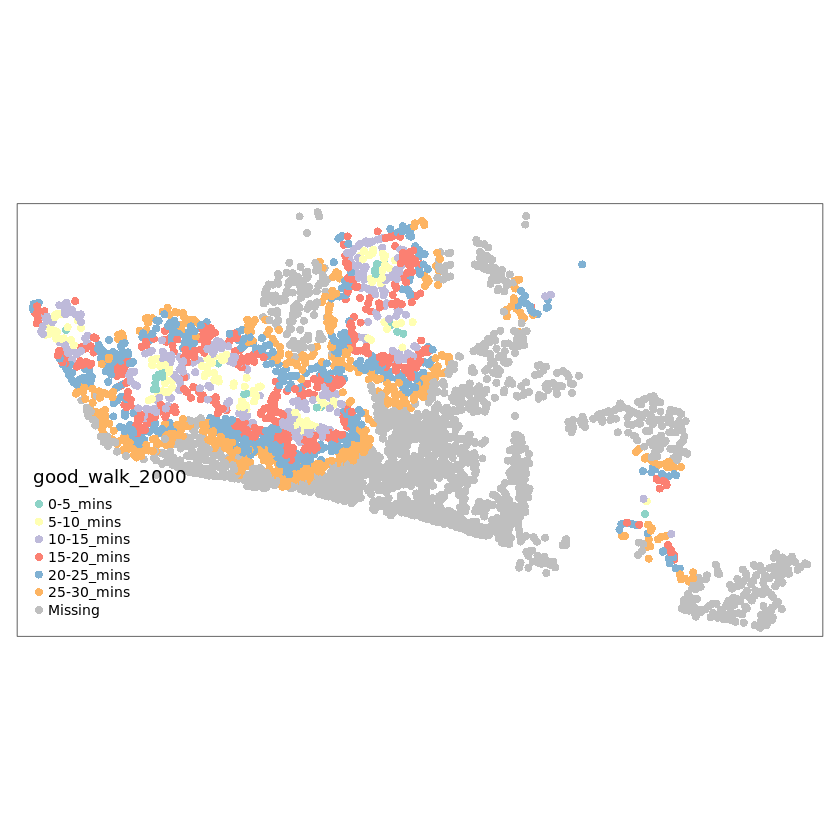

In [41]:
tm_shape(brighton_houses) + tm_symbols(col="good_walk_2000", size=0.2, border.lwd=0)

## Quality of secondary schools walking function

In [75]:
walk_condense_data <- function(sec_schools_geocoded, brighton_houses, start_year, end_year) {
  # Set parameters
  mode <- c("WALK")
  max_walk_time <- 30 # minutes
  max_trip_duration <- 30 # minutes
  departure_datetime <- as.POSIXct("01-12-2022 8:30:00", format = "%d-%m-%Y %H:%M:%S")
  
  for (year in start_year:end_year) {
    # Extract rows with 'Good' or 'Outstanding' for the given year
    good_year <- paste0(year)
    good_data <- sec_schools_geocoded[sec_schools_geocoded[[good_year]] %in% c("Good", "Outstanding"), ]
    
    # Calculate travel time matrix by transit
    ttm_good_walk <- travel_time_matrix(r5r_core = r5r_core,
                                        origins = good_data,
                                        destinations = brighton_houses,
                                        mode = mode,
                                        departure_datetime = departure_datetime,
                                        max_walk_time = max_walk_time,
                                        max_trip_duration = max_trip_duration)
    # Remove duplicates from each postcode (in case a postcode is within 30 mins walking from more than 1 Good/Oustanding schools)
      #from_id = schools, to_id = houses/postcodes
      ttm_good_walk <- ttm_good_walk %>%
      group_by(to_id) %>% 
      arrange(travel_time_p50) %>%
      slice_head(n = 1) %>% 
      ungroup()
      
    # Remove duplicates in 'to_id' column
    duplicates_ttm_good_walk <- duplicated(ttm_good_walk$to_id)
    duplicates_brighton_houses <- duplicated(brighton_houses$id)
    
    if (any(duplicates_ttm_good_walk) || any(duplicates_brighton_houses)) {
      print("Duplicates found! Please handle duplicates before performing the left join.")
      return(NULL)
    } else {
      # Perform left join to merge dataframes
      brighton_houses <- left_join(brighton_houses, ttm_good_walk, by = c("id" = "to_id"))
    }
    
    # Create a new categorical column based on travel time
    breaks <- c(0, 5, 10, 15, 20, 25, 30)
    labels <- c("0-5_mins", "5-10_mins", "10-15_mins", "15-20_mins", "20-25_mins", "25-30_mins")
    brighton_houses[[paste0(year, "_good_sec_walk")]] <- cut(brighton_houses$travel_time_p50, breaks = breaks,
                                                         labels = labels, include.lowest = TRUE, right = FALSE)
    
    # Drop unnecessary columns
    brighton_houses <- brighton_houses[, !(names(brighton_houses) %in% c('from_id', 'travel_time_p50'))]
  }
  
  return(brighton_houses)
}

In [76]:
result_walk <- walk_condense_data(sec_schools_geocoded, brighton_houses, 2000, 2019)

In [77]:
colnames(result_walk)

[1] "id"                 "to_id"              "walk_nearest_sec"  
 [4] "2000_good_sec_walk" "2001_good_sec_walk" "2002_good_sec_walk"
 [7] "2003_good_sec_walk" "2004_good_sec_walk" "2005_good_sec_walk"
[10] "2006_good_sec_walk" "2007_good_sec_walk" "2008_good_sec_walk"
[13] "2009_good_sec_walk" "2010_good_sec_walk" "2011_good_sec_walk"
[16] "2012_good_sec_walk" "2013_good_sec_walk" "2014_good_sec_walk"
[19] "2015_good_sec_walk" "2016_good_sec_walk" "2017_good_sec_walk"
[22] "2018_good_sec_walk" "geometry"           "2019_good_sec_walk"

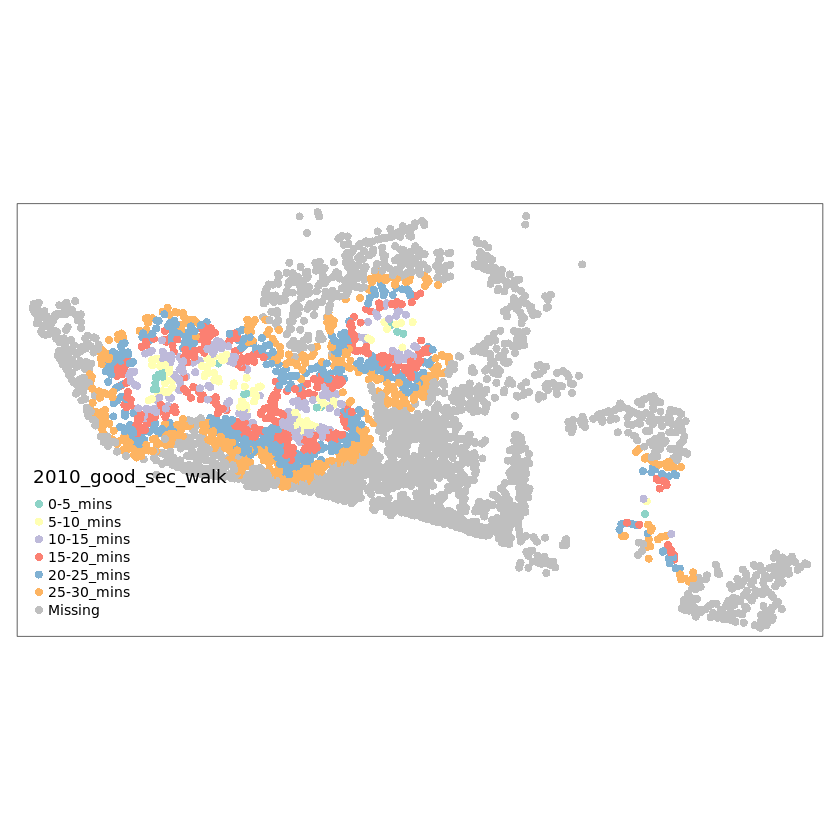

In [79]:
tm_shape(result_walk) + tm_symbols(col="2010_good_sec_walk", size=0.2, border.lwd=0)

In [80]:
# # ### Save 
# # Extract latitude and longitude coordinates from 'geometry' column
# result_walk$latitude <- st_coordinates(st_geometry(result_walk))[ ,2]
# result_walk$longitude <- st_coordinates(st_geometry(result_walk))[ ,1]

# # Drop geom column
# result_walk <- result_walk[, !names(result_walk) %in% "geometry"]

# # Save the updated dataframe as a CSV file
# write.csv(result_walk, "data/schools_geo/secschools_geo_walk.csv", row.names = FALSE)

## Quality of schools bus function

In [81]:
bus_condense_data <- function(sec_schools_geocoded, brighton_houses, start_year, end_year) {
  # Set parameters
  mode <- c("WALK", "BUS")
  max_walk_time <- 20 # minutes
  max_trip_duration <- 45 # minutes
  departure_datetime <- as.POSIXct("01-12-2022 8:30:00", format = "%d-%m-%Y %H:%M:%S")
  
  for (year in start_year:end_year) {
    # Extract rows with 'Good' or 'Outstanding' for the given year
    good_year <- paste0(year)
    good_data <- sec_schools_geocoded[sec_schools_geocoded[[good_year]] %in% c("Good", "Outstanding"), ]
    
    # Calculate travel time matrix by transit
    ttm_good_bus <- travel_time_matrix(r5r_core = r5r_core,
                                        origins = good_data,
                                        destinations = brighton_houses,
                                        mode = mode,
                                        departure_datetime = departure_datetime,
                                        max_walk_time = max_walk_time,
                                        max_trip_duration = max_trip_duration)
    # Remove duplicates from each postcode (in case a postcode is within 30 mins walking from more than 1 Good/Oustanding schools)
      #from_id = schools, to_id = houses/postcodes
      ttm_good_bus <- ttm_good_bus %>%
      group_by(to_id) %>% 
      arrange(travel_time_p50) %>%
      slice_head(n = 1) %>% 
      ungroup()
      
    # Remove duplicates in 'to_id' column
    duplicates_ttm_good_bus <- duplicated(ttm_good_bus$to_id)
    duplicates_brighton_houses <- duplicated(brighton_houses$id)
    
    if (any(duplicates_ttm_good_bus) || any(duplicates_brighton_houses)) {
      print("Duplicates found! Please handle duplicates before performing the left join.")
      return(NULL)
    } else {
      # Perform left join to merge dataframes
      brighton_houses <- left_join(brighton_houses, ttm_good_bus, by = c("id" = "to_id"))
    }
    
    # Create a new categorical column based on travel time
    breaks <- c(0, 5, 10, 15, 20, 25, 30, 35, 40, 45)
    labels <- c("0-5_mins", "5-10_mins", "10-15_mins", "15-20_mins", "20-25_mins", "25-30_mins", "30-35_mins", "35-40_mins", "40-45_mins")
    brighton_houses[[paste0(year, "_good_sec_bus")]] <- cut(brighton_houses$travel_time_p50, breaks = breaks,
                                                         labels = labels, include.lowest = TRUE, right = FALSE)
    
    # Drop unnecessary columns
    brighton_houses <- brighton_houses[, !(names(brighton_houses) %in% c('from_id', 'travel_time_p50'))]
  }
  
  return(brighton_houses)
}

In [82]:
result_bus <- bus_condense_data(sec_schools_geocoded, brighton_houses, 2000, 2019)

In [83]:
colnames(result_bus)

[1] "id"                "to_id"             "walk_nearest_sec" 
 [4] "2000_good_sec_bus" "2001_good_sec_bus" "2002_good_sec_bus"
 [7] "2003_good_sec_bus" "2004_good_sec_bus" "2005_good_sec_bus"
[10] "2006_good_sec_bus" "2007_good_sec_bus" "2008_good_sec_bus"
[13] "2009_good_sec_bus" "2010_good_sec_bus" "2011_good_sec_bus"
[16] "2012_good_sec_bus" "2013_good_sec_bus" "2014_good_sec_bus"
[19] "2015_good_sec_bus" "2016_good_sec_bus" "2017_good_sec_bus"
[22] "2018_good_sec_bus" "geometry"          "2019_good_sec_bus"

In [84]:
head(result_bus)

id      to_id   walk_nearest_sec 2000_good_sec_bus 2001_good_sec_bus
1 BN1 1AD BN3 6ND 50               30-35_mins        30-35_mins       
2 BN1 1AJ BN3 6ND 50               30-35_mins        30-35_mins       
3 BN1 1AL BN3 6ND 49               30-35_mins        30-35_mins       
4 BN1 1AN BN3 6ND 47               30-35_mins        30-35_mins       
5 BN1 1AP BN3 6ND 51               30-35_mins        30-35_mins       
6 BN1 1BG BN3 6ND 48               30-35_mins        30-35_mins       
  2002_good_sec_bus 2003_good_sec_bus 2004_good_sec_bus 2005_good_sec_bus
1 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
2 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
3 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
4 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
5 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
6 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
  2006_good_sec_bus geometry                   ⋯ 2011_good_sec_bus
1 30-35_mins        POINT (-0.142167 50.82169) ⋯ 30-35_mins       
2 30-35_mins        POINT (-0.14256 50.82145)  ⋯ 30-35_mins       
3 30-35_mins        POINT (-0.142961 50.82136) ⋯ 30-35_mins       
4 30-35_mins        POINT (-0.1435 50.82209)   ⋯ 30-35_mins       
5 30-35_mins        POINT (-0.143707 50.8208)  ⋯ 30-35_mins       
6 30-35_mins        POINT (-0.1421 50.82231)   ⋯ 30-35_mins       
  2012_good_sec_bus 2013_good_sec_bus 2014_good_sec_bus 2015_good_sec_bus
1 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
2 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
3 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
4 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
5 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
6 30-35_mins        30-35_mins        30-35_mins        30-35_mins       
  2016_good_sec_bus 2017_good_sec_bus 2018_good_sec_bus
1 30-35_mins        30-35_mins        30-35_mins       
2 30-35_mins        30-35_mins        30-35_mins       
3 30-35_mins        30-35_mins        30-35_mins       
4 30-35_mins        30-35_mins        30-35_mins       
5 30-35_mins        30-35_mins        30-35_mins       
6 30-35_mins        30-35_mins        30-35_mins       
  geometry                   2019_good_sec_bus
1 POINT (-0.142167 50.82169) 30-35_mins       
2 POINT (-0.14256 50.82145)  30-35_mins       
3 POINT (-0.142961 50.82136) 30-35_mins       
4 POINT (-0.1435 50.82209)   30-35_mins       
5 POINT (-0.143707 50.8208)  30-35_mins       
6 POINT (-0.1421 50.82231)   30-35_mins

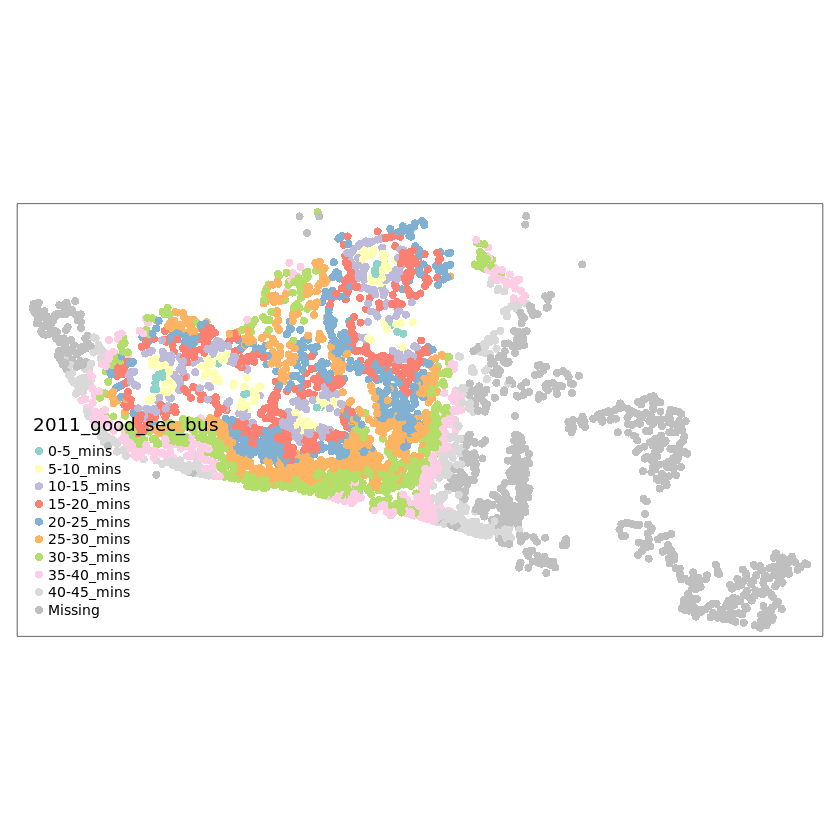

In [86]:
tm_shape(result_bus) + tm_symbols(col="2011_good_sec_bus", size=0.2, border.lwd=0)

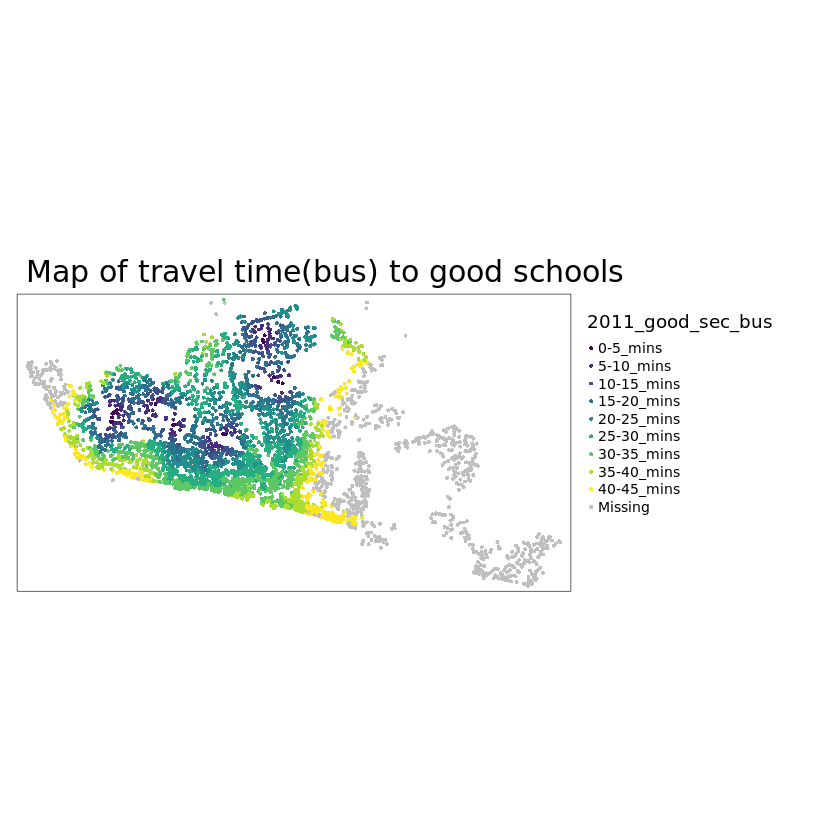

In [87]:
tm_shape(result_bus) + 
tm_symbols(col="2011_good_sec_bus", palette='viridis', size=0.05, border.lwd=0) +
tm_layout(main.title = 'Map of travel time(bus) to good schools',legend.outside = TRUE)

In [88]:
# ### Save 
# # Extract latitude and longitude coordinates from 'geometry' column
# result_bus$latitude <- st_coordinates(st_geometry(result_bus))[ ,2]
# result_bus$longitude <- st_coordinates(st_geometry(result_bus))[ ,1]

# # Drop geom column
# result_bus <- result_bus[, !names(result_bus) %in% "geometry"]

# # Save the updated dataframe as a CSV file
# write.csv(result_bus, "schools_geo/secschools_geo_bus.csv", row.names = FALSE)

In [89]:
# ## Save 
# # Convert st objects to dataframes for merging
# result_walk_df <- as.data.frame(result_walk)
# result_bus_df <- as.data.frame(result_bus)

# # Merge the dataframes based on common columns
# merged_df <- merge(result_walk_df, result_bus_df, by = c("id", "walk_nearest_sec", "geometry"))

# # Convert the merged dataframe back to an st object
# merged_result <- st_as_sf(merged_df)

# # Extract latitude and longitude coordinates from 'geometry' column
# merged_result$latitude <- st_coordinates(st_geometry(merged_result))[ ,2]
# merged_result$longitude <- st_coordinates(st_geometry(merged_result))[ ,1]

# # Drop geom column
# merged_result <- merged_result[, !names(merged_result) %in% "geometry"]

# # Save the updated dataframe as a CSV file
# write.csv(merged_result, "schools_geo/secschools_geo_both.csv", row.names = FALSE)

In [92]:
#st_write(merged_result, 'schools_geo/shapefiles/secschools_geo_both.shp', append=FALSE)

# Primary schools

In [26]:
brighton_houses2 <- brighton_postcodes%>%
  #remove NAs or 0
  filter(long != 0 )%>%
  filter(lat != 0)%>%
  st_as_sf(., coords = c("long","lat"), 
                   crs = 4326)

names(brighton_houses2)[names(brighton_houses2) == "postcode"] <- "id"

In [27]:
# pri schools
## leftjoin pr schools with lat lon data
pri_schools <- read_csv("schools_geo/ks2_hist_df.csv")

names(postcode_df)[names(postcode_df) == "pcds"] <- "id"

pri_schools <- left_join(pri_schools, postcode_df, by=c("School postcode" = "id"))

pri_schools_geocoded <- pri_schools%>%
  #remove NAs or 0
  filter(long != 0 )%>%
  filter(lat != 0)%>%
  st_as_sf(., coords = c("long","lat"), 
                   crs = 4326)

names(pri_schools_geocoded)[names(pri_schools_geocoded) == "School postcode"] <- "id"
names(pri_schools_geocoded)[names(pri_schools_geocoded) == "School name"] <- "school_name"

Rows: 47 Columns: 20
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (19): School name, School postcode, 2003, 2004, 2005, 2006, 2007, 2008, ...
dbl  (1): LAESTAB

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [30]:
##save geocoded schools as shpfile
### st_write(pri_schools_geocoded, 'data/schools_geo/shapefiles/prischools_geocoded.shp')

Warning message in abbreviate_shapefile_names(obj):
“Field names abbreviated for ESRI Shapefile driver”


Deleting layer `prischools_geocoded' using driver `ESRI Shapefile'
Writing layer `prischools_geocoded' to data source 
  `schools_geo/shapefiles/prischools_geocoded.shp' using driver `ESRI Shapefile'
Writing 47 features with 20 fields and geometry type Point.


### Obtain nearest school for all postcodes

In [31]:
# Set parameters
mode = c("WALK")
max_walk_time = 60 # minutes
max_trip_duration = 60 # minutes
departure_datetime = as.POSIXct("01-12-2022 8:30:00",
                                 format = "%d-%m-%Y %H:%M:%S")

# Calculate the travel time matrix by Transit
ttm_nearest_pri = travel_time_matrix(r5r_core = r5r_core,
                          origins = brighton_houses2,
                          destinations = pri_schools_geocoded,
                          mode = mode,
                          departure_datetime = departure_datetime,
                          max_walk_time = max_walk_time,
                          max_trip_duration = max_trip_duration)

head(ttm_nearest_pri)

from_id,to_id,travel_time_p50
<chr>,<chr>,<int>
BN1 1AD,BN1 5PR,35
BN1 1AD,BN2 0BN,27
BN1 1AD,BN3 6NB,48
BN1 1AD,BN1 3LP,15
BN1 1AD,BN3 3YT,51
BN1 1AD,BN2 9ZE,39


In [32]:
nrow(ttm_nearest_pri)

[1] 58376

In [33]:
ttm_nearest_pri <- ttm_nearest_pri %>%
  group_by(from_id) %>% 
  arrange(travel_time_p50) %>%
  slice_head(n = 1) %>% 
  ungroup()

nrow(ttm_nearest_pri)

[1] 3902

In [34]:
# Check for duplicates in 'id' column of df1
duplicates_ttm_nearest_pri <- duplicated(ttm_nearest_pri$from_id)
# Check for duplicates in 'id' column of df2
duplicates_brighton_houses2 <- duplicated(brighton_houses2$id)

# Check if there are duplicates in df1 or df2
if (any(duplicates_ttm_nearest_pri) || any(duplicates_brighton_houses2)) {
  print("Duplicates found! Please handle duplicates before performing left join.")
} else {
  # Perform the left join, walk time bands from rail station to postcodes
  brighton_houses2 <- left_join(brighton_houses2, ttm_nearest_pri, by=c(id = "from_id"))
  # Print the resulting merged data frame
  print(brighton_houses2)
}

Simple feature collection with 3902 features and 3 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -0.235465 ymin: 50.80051 xmax: -0.02655 ymax: 50.87138
Geodetic CRS:  WGS 84
First 10 features:
        id   to_id travel_time_p50                   geometry
1  BN1 1AD BN1 1AL               3 POINT (-0.142167 50.82169)
2  BN1 1AJ BN1 1AL               1  POINT (-0.14256 50.82145)
3  BN1 1AL BN1 1AL               0 POINT (-0.142961 50.82136)
4  BN1 1AN BN1 1AL               2   POINT (-0.1435 50.82209)
5  BN1 1AP BN1 1AL               2  POINT (-0.143707 50.8208)
6  BN1 1BG BN1 1AL               3   POINT (-0.1421 50.82231)
7  BN1 1EA BN1 1AL               8  POINT (-0.13946 50.82263)
8  BN1 1EG BN1 1AL               9 POINT (-0.138162 50.82136)
9  BN1 1EH BN1 1AL               9 POINT (-0.137542 50.82162)
10 BN1 1EJ BN1 1AL              12 POINT (-0.136211 50.82151)


In [35]:
print(sum(is.na(brighton_houses2$travel_time_p50)))
#0 nas

[1] 0


In [36]:
colnames(brighton_houses2)[colnames(brighton_houses2) == "travel_time_p50"] <- "walk_nearest_pri"

In [ ]:
pri_schools_geocoded_nodup <- subset(pri_schools_geocoded, id != 'BN41 2LA')
nrow(pri_schools_geocoded_nodup)

In [ ]:
# Brackenbury and St Nic CofE have same postcode hence:
# Create base dictionary
postcode_prischool_dict <- setNames(pri_schools_geocoded_nodup$school_name, pri_schools_geocoded_nodup$id)

# Sample key-value pairs to add
add_postcodes <- c('BN41 2LA')
add_school_names <- c('St Nicolas CofE Junior School and Brackenbury Primary School')

# Adding custom key-value pairs to the dictionary
postcode_prischool_dict[add_postcodes] <- add_school_names

# Use match() and the dictionary to replace postcodes with school names
brighton_houses2$nearest_pri_name <- postcode_prischool_dict[match(brighton_houses2$to_id, names(postcode_prischool_dict))]

In [37]:
head(brighton_houses2)

,id,walk_nearest_pri,geometry
,<chr>,<int>,<POINT [°]>
1,BN1 1AD,3,POINT (-0.142167 50.82169)
2,BN1 1AJ,1,POINT (-0.14256 50.82145)
3,BN1 1AL,0,POINT (-0.142961 50.82136)
4,BN1 1AN,2,POINT (-0.1435 50.82209)
5,BN1 1AP,2,POINT (-0.143707 50.8208)
6,BN1 1BG,3,POINT (-0.1421 50.82231)


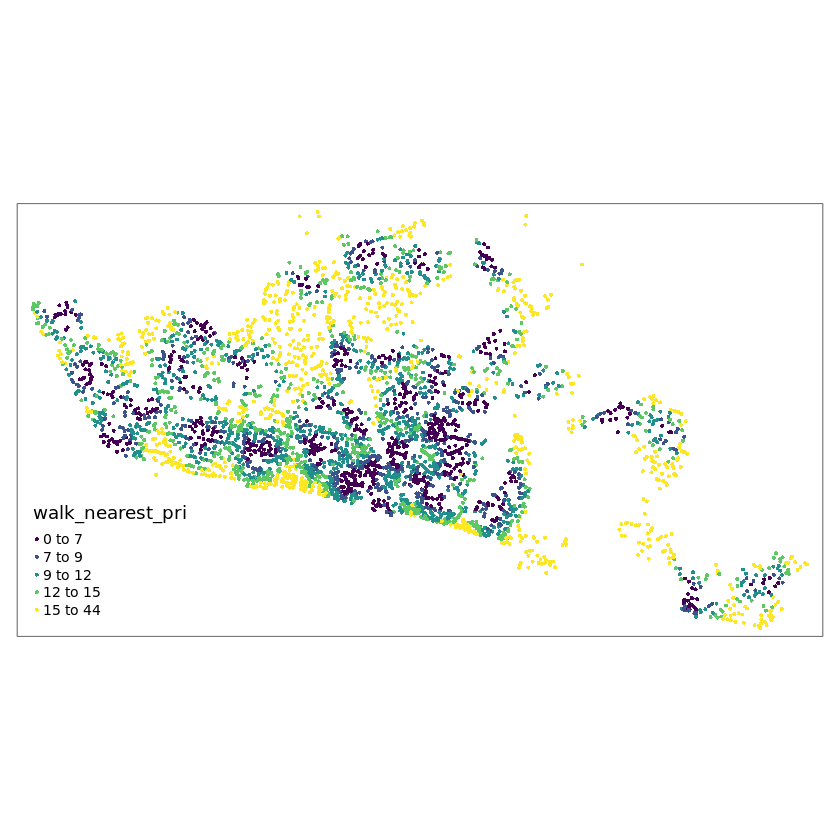

In [38]:
tm_shape(brighton_houses2) + 
tm_symbols(col="walk_nearest_pri", palette='viridis', style='quantile', size=0.05, border.lwd=0)

### Obtain postcodes within 30 mins walking

In [93]:
pri_walk_condense <- function(pri_schools_geocoded, brighton_houses2, start_year, end_year) {
  # Set parameters
  mode <- c("WALK")
  max_walk_time <- 30 # minutes
  max_trip_duration <- 30 # minutes
  departure_datetime <- as.POSIXct("01-12-2022 8:30:00", format = "%d-%m-%Y %H:%M:%S")
  
  for (year in start_year:end_year) {
    # Extract rows with 'Good' or 'Outstanding' for the given year
    good_year <- paste0(year)
    good_data <- pri_schools_geocoded %>% 
      filter(.data[[good_year]] %in% c("Good", "Outstanding"))
    
    # Calculate travel time matrix by transit
    ttm_good_walk_pri <- travel_time_matrix(r5r_core = r5r_core,
                                        origins = good_data,
                                        destinations = brighton_houses2,
                                        mode = mode,
                                        departure_datetime = departure_datetime,
                                        max_walk_time = max_walk_time,
                                        max_trip_duration = max_trip_duration)
    # Remove duplicates from each postcode (in case a postcode is within 30 mins walking from more than 1 Good/Oustanding schools)
    # from_id = schools, to_id = houses/postcodes
    ttm_good_walk_pri <- ttm_good_walk_pri %>%
      group_by(to_id) %>% 
      arrange(travel_time_p50) %>%
      slice_head(n = 1) %>% 
      ungroup()
    
    # Remove duplicates in 'to_id' column
    duplicates_ttm_good_walk_pri <- duplicated(ttm_good_walk_pri$to_id)
    duplicates_brighton_houses2 <- duplicated(brighton_houses2$id)
    
    if (any(duplicates_ttm_good_walk_pri) || any(duplicates_brighton_houses2)) {
      print("Duplicates found! Please handle duplicates before performing the left join.")
      return(NULL)
    } else {
      # Perform left join to merge data frames
      brighton_houses2 <- left_join(brighton_houses2, ttm_good_walk_pri, by = c("id" = "to_id"))
    }
    
    # Create a new categorical column based on travel time
    breaks <- c(0, 5, 10, 15, 20, 25, 30)
    labels <- c("0-5_mins", "5-10_mins", "10-15_mins", "15-20_mins", "20-25_mins", "25-30_mins")
    brighton_houses2[[paste0(year, "_good_pri_walk")]] <- cut(brighton_houses2$travel_time_p50, breaks = breaks,
                                                         labels = labels, include.lowest = TRUE, right = FALSE)
    
    # Drop unnecessary columns
    brighton_houses2 <- brighton_houses2[, !(names(brighton_houses2) %in% c('from_id', 'travel_time_p50'))]
  }
  
  return(brighton_houses2)
} 

In [94]:
pri_walk <- pri_walk_condense(pri_schools_geocoded, brighton_houses2, 2003, 2019)

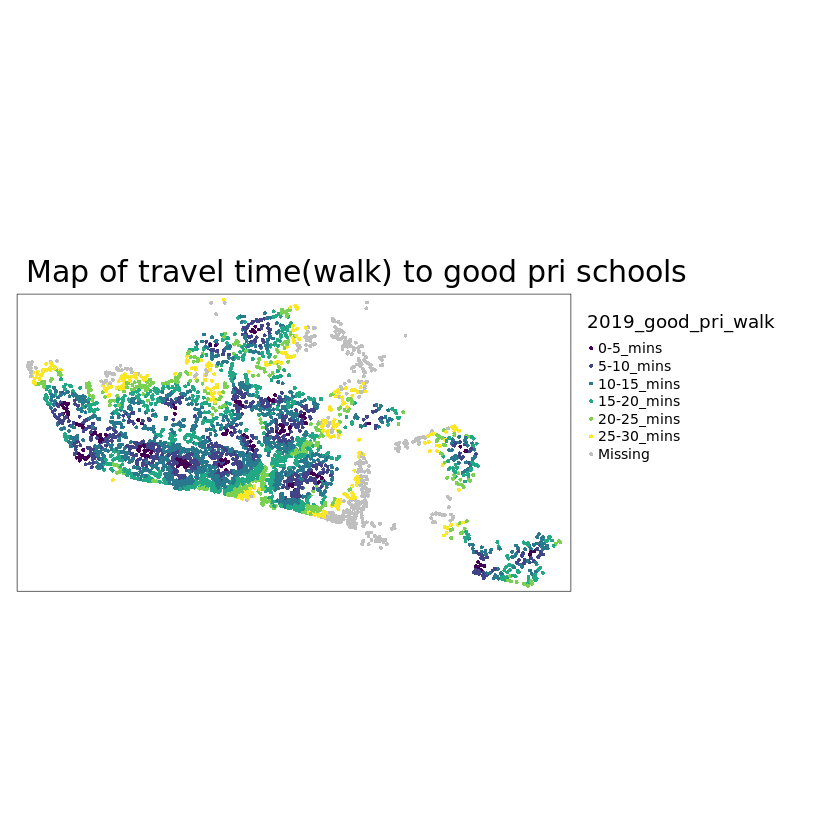

In [95]:
tm_shape(pri_walk) + 
tm_symbols(col="2019_good_pri_walk", palette='viridis', size=0.05, border.lwd=0) +
tm_layout(main.title = 'Map of travel time(walk) to good pri schools',legend.outside = TRUE)

In [96]:
# ### Save 
# # Extract latitude and longitude coordinates from 'geometry' column
# pri_walk$latitude <- st_coordinates(st_geometry(pri_walk))[ ,2]
# pri_walk$longitude <- st_coordinates(st_geometry(pri_walk))[ ,1]

# # Drop geom column
# pri_walk <- pri_walk[, !names(pri_walk) %in% "geometry"]

# # Save the updated dataframe as a CSV file
# write.csv(pri_walk, "data/schools_geo/prischools_geo_walk.csv", row.names = FALSE)

## Quality of pri schools bus function

In [97]:
pri_bus_condense <- function(pri_schools_geocoded, brighton_houses2, start_year, end_year) {
  # Set parameters
  mode <- c("WALK", "BUS")
  max_walk_time <- 20 # minutes
  max_trip_duration <- 45 # minutes
  departure_datetime <- as.POSIXct("01-12-2022 8:30:00", format = "%d-%m-%Y %H:%M:%S")
  
  for (year in start_year:end_year) {
    # Extract rows with 'Good' or 'Outstanding' for the given year
    good_year <- paste0(year)
    good_data <- pri_schools_geocoded %>% 
      filter(.data[[good_year]] %in% c("Good", "Outstanding"))
    
    # Calculate travel time matrix by transit
    ttm_good_bus_pri <- travel_time_matrix(r5r_core = r5r_core,
                                        origins = good_data,
                                        destinations = brighton_houses2,
                                        mode = mode,
                                        departure_datetime = departure_datetime,
                                        max_walk_time = max_walk_time,
                                        max_trip_duration = max_trip_duration)
    # Remove duplicates from each postcode (in case a postcode is within 30 mins walking from more than 1 Good/Oustanding schools)
    # from_id = schools, to_id = houses/postcodes
    ttm_good_bus_pri <- ttm_good_bus_pri %>%
      group_by(to_id) %>% 
      arrange(travel_time_p50) %>%
      slice_head(n = 1) %>% 
      ungroup()
    
    # Remove duplicates in 'to_id' column
    duplicates_ttm_good_bus_pri <- duplicated(ttm_good_bus_pri$to_id)
    duplicates_brighton_houses2 <- duplicated(brighton_houses2$id)
    
    if (any(duplicates_ttm_good_bus_pri) || any(duplicates_brighton_houses2)) {
      print("Duplicates found! Please handle duplicates before performing the left join.")
      return(NULL)
    } else {
      # Perform left join to merge data frames
      brighton_houses2 <- left_join(brighton_houses2, ttm_good_bus_pri, by = c("id" = "to_id"))
    }
    
    # Create a new categorical column based on travel time
    breaks <- c(0, 5, 10, 15, 20, 25, 30, 35, 40, 45)
    labels <- c("0-5_mins", "5-10_mins", "10-15_mins", "15-20_mins", "20-25_mins", "25-30_mins", "30-35_mins", "35-40_mins", "40-45_mins")
    brighton_houses2[[paste0(year, "_good_pri_bus")]] <- cut(brighton_houses2$travel_time_p50, breaks = breaks,
                                                         labels = labels, include.lowest = TRUE, right = FALSE)
    
    # Drop unnecessary columns
    brighton_houses2 <- brighton_houses2[, !(names(brighton_houses2) %in% c('from_id', 'travel_time_p50'))]
  }
  
  return(brighton_houses2)
} 

In [98]:
pri_bus <- pri_bus_condense(pri_schools_geocoded, brighton_houses2, 2003, 2019)

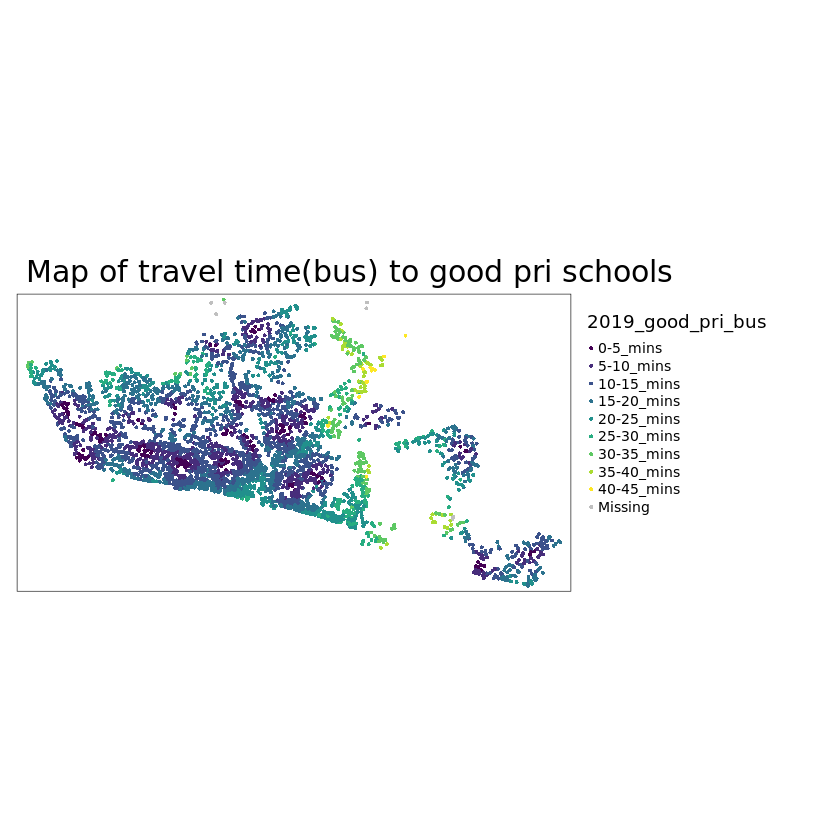

In [99]:
tm_shape(pri_bus) + 
tm_symbols(col="2019_good_pri_bus", palette='viridis', size=0.05, border.lwd=0) +
tm_layout(main.title = 'Map of travel time(bus) to good pri schools',legend.outside = TRUE)

In [100]:
# ### Save 
# # Extract latitude and longitude coordinates from 'geometry' column
# pri_bus$latitude <- st_coordinates(st_geometry(pri_bus))[ ,2]
# pri_bus$longitude <- st_coordinates(st_geometry(pri_bus))[ ,1]

# # Drop geom column
# pri_bus <- pri_bus[, !names(pri_bus) %in% "geometry"]

# # Save the updated dataframe as a CSV file
# write.csv(pri_bus, "data/schools_geo/prischools_geo_bus.csv", row.names = FALSE)

In [102]:
# ## Save 
# # Convert st objects to dataframes for merging
# pri_walk_df <- as.data.frame(pri_walk)
# pri_bus_df <- as.data.frame(pri_bus)

# # Merge the dataframes based on common columns
# merged_pri_df <- merge(pri_walk_df, pri_bus_df, by = c("id", "walk_nearest_pri", "geometry"))

# # Convert the merged dataframe back to an st object
# merged_pri_result <- st_as_sf(merged_pri_df)

# # Extract latitude and longitude coordinates from 'geometry' column
# merged_pri_result$latitude <- st_coordinates(st_geometry(merged_pri_result))[ ,2]
# merged_pri_result$longitude <- st_coordinates(st_geometry(merged_pri_result))[ ,1]

# # Drop geom column
# merged_pri_result <- merged_pri_result[, !names(merged_pri_result) %in% "geometry"]

# # Save the updated dataframe as a CSV file
# write.csv(merged_pri_result, "data/schools_geo/prischools_geo_both.csv", row.names = FALSE)

In [ ]:
###st_write(merged_pri_result, 'data/schools_geo/shapefiles/prischools_geo_both.shp')
#terrible field names

# Merge pri and sec data- with postcodes into one df

In [105]:
secschools_geo_both = read_csv("schools_geo/secschools_geo_both.csv")
head(secschools_geo_both)


New names:
• `` -> `...46`
Rows: 3902 Columns: 46
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (43): id, 2000_good_sec_walk, 2001_good_sec_walk, 2002_good_sec_walk, 20...
dbl  (3): walk_nearest_sec, latitude, longitude

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,walk_nearest_sec,2000_good_sec_walk,2001_good_sec_walk,2002_good_sec_walk,2003_good_sec_walk,2004_good_sec_walk,2005_good_sec_walk,2006_good_sec_walk,2007_good_sec_walk,⋯,2014_good_sec_bus,2015_good_sec_bus,2016_good_sec_bus,2017_good_sec_bus,2018_good_sec_bus,2019_good_sec_bus,latitude,longitude,geometry,...46
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
BN1 1AD,50,NA,NA,NA,NA,NA,NA,NA,NA,⋯,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,50.82169,-0.142167,c(-0.142167,50.821691)
BN1 1AJ,50,NA,NA,NA,NA,NA,NA,NA,NA,⋯,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,50.82145,-0.142560,c(-0.14256,50.821451)
BN1 1AL,49,NA,NA,NA,NA,NA,NA,NA,NA,⋯,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,50.82136,-0.142961,c(-0.142961,50.821362)
BN1 1AN,47,NA,NA,NA,NA,NA,NA,NA,NA,⋯,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,50.82209,-0.143500,c(-0.1435,50.822086)
BN1 1AP,51,NA,NA,NA,NA,NA,NA,NA,NA,⋯,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,50.82080,-0.143707,c(-0.143707,50.820804)
BN1 1BG,48,NA,NA,NA,NA,NA,NA,NA,NA,⋯,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,30-35_mins,50.82231,-0.142100,c(-0.1421,50.82231)


In [107]:
nrow(secschools_geo_both)

[1] 3902

In [106]:
prischools_geo_both = read_csv("schools_geo/prischools_geo_both.csv")
head(prischools_geo_both)

New names:
• `` -> `...40`
Rows: 3902 Columns: 40
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (37): id, 2003_good_pri_walk, 2004_good_pri_walk, 2005_good_pri_walk, 20...
dbl  (3): walk_nearest_pri, latitude, longitude

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,walk_nearest_pri,2003_good_pri_walk,2004_good_pri_walk,2005_good_pri_walk,2006_good_pri_walk,2007_good_pri_walk,2008_good_pri_walk,2009_good_pri_walk,2010_good_pri_walk,⋯,2014_good_pri_bus,2015_good_pri_bus,2016_good_pri_bus,2017_good_pri_bus,2018_good_pri_bus,2019_good_pri_bus,latitude,longitude,geometry,...40
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
BN1 1AD,3,0-5_mins,0-5_mins,15-20_mins,0-5_mins,0-5_mins,15-20_mins,15-20_mins,15-20_mins,⋯,0-5_mins,20-25_mins,20-25_mins,0-5_mins,15-20_mins,20-25_mins,50.82169,-0.142167,c(-0.142167,50.821691)
BN1 1AJ,1,0-5_mins,0-5_mins,10-15_mins,0-5_mins,0-5_mins,10-15_mins,10-15_mins,10-15_mins,⋯,0-5_mins,20-25_mins,20-25_mins,0-5_mins,10-15_mins,20-25_mins,50.82145,-0.142560,c(-0.14256,50.821451)
BN1 1AL,0,0-5_mins,0-5_mins,10-15_mins,0-5_mins,0-5_mins,10-15_mins,10-15_mins,10-15_mins,⋯,0-5_mins,20-25_mins,20-25_mins,0-5_mins,10-15_mins,20-25_mins,50.82136,-0.142961,c(-0.142961,50.821362)
BN1 1AN,2,0-5_mins,0-5_mins,10-15_mins,0-5_mins,0-5_mins,10-15_mins,10-15_mins,10-15_mins,⋯,0-5_mins,20-25_mins,20-25_mins,0-5_mins,10-15_mins,20-25_mins,50.82209,-0.143500,c(-0.1435,50.822086)
BN1 1AP,2,0-5_mins,0-5_mins,15-20_mins,0-5_mins,0-5_mins,15-20_mins,15-20_mins,15-20_mins,⋯,0-5_mins,25-30_mins,25-30_mins,0-5_mins,15-20_mins,20-25_mins,50.82080,-0.143707,c(-0.143707,50.820804)
BN1 1BG,3,0-5_mins,0-5_mins,10-15_mins,0-5_mins,0-5_mins,10-15_mins,10-15_mins,10-15_mins,⋯,0-5_mins,20-25_mins,20-25_mins,0-5_mins,10-15_mins,20-25_mins,50.82231,-0.142100,c(-0.1421,50.82231)


In [109]:
nrow(prischools_geo_both)

[1] 3902

In [111]:
postcodes_sch_acc <- merge(secschools_geo_both, prischools_geo_both, by = "id", all = TRUE)

In [112]:
nrow(postcodes_sch_acc)

[1] 3902

In [113]:
# write.csv(postcodes_sch_acc, "schools_geo/allschools_geo_both.csv", row.names = FALSE)